# Quora question pairs

## 1. Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import csv
import codecs
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation

from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-question/quora_test.csv
/kaggle/input/quora-question/quora_train.csv
/kaggle/input/bertembedding/bert-for-humans-tutorial-baseline
/kaggle/input/embedding/GoogleNews-vectors-negative300.bin
/kaggle/input/amazon-google/Amazon_test.csv
/kaggle/input/amazon-google/Amazon_train.csv
/kaggle/input/amazon-google/Google_train.csv
/kaggle/input/amazon-google/Google_test.csv
/kaggle/input/amazon-google/AG_perfect_matching_test.csv
/kaggle/input/amazon-google/AG_perfect_matching_train.csv


## 2. Data preprocessing

In [2]:
# Load the training data
quora_train = pd.read_csv('/kaggle/input/quora-question/quora_train.csv')
quora_train = quora_train.drop('Unnamed: 0', axis = 1)
quora_train

,id,qid1,qid2,question1,question2,is_duplicate
0,195840,386541,386542,How does banning 500 & 1000 rupee notes solve ...,Will the ban on 500 & 1000 rupee notes really ...,1
1,252241,496583,496584,What is the hardest thing(s) about raising chi...,What is the hardest thing(s) about raising chi...,0
2,249224,490718,490719,Who are Utopia's top competitors?,Who are Axis 41's top competitors?,0
3,125536,248723,248724,I want to improve my reading skill by reading ...,How can reading newspaper help me improve my E...,0
4,390237,762803,762804,How do I gain weight in naturally way?,How to gain weight ?,1
...,...,...,...,...,...,...
323475,182164,359776,359777,"Who will win, Trump or Clinton?","Who will be indicted first, Trump or Clinton?",0
323476,280219,550879,550880,Which is the best earphone under 1000rs?,What is the best earphone under 1000 rs?,1
323477,56173,111758,111759,What songs make you cry and why?,Which songs did make you cry ever?,1
323478,231498,456152,456153,Taste of sperm?,What is the taste of sperm?,1


In [3]:
# Load the test data
quora_test = pd.read_csv('/kaggle/input/quora-question/quora_test.csv')
quora_test = quora_test.drop('Unnamed: 0', axis = 1)
quora_test

,id,qid1,qid2,question1,question2,is_duplicate
0,384611,752053,752054,What are the pros and cons of Legalzoom-genera...,Where can I read reviews of LegalZoom?,0
1,258398,508576,508577,Why does ready-to-eat poha absorb water instan...,Ultimate teen patti hacker?,0
2,234932,462847,462848,How apps like paytm earn profit when they are ...,How does Paytm earn by giving extra cash back ...,1
3,347622,681123,681124,What daily habits can greatly upgrade life?,What are your daily habits that improve your p...,1
4,388186,758881,758882,What video game world would you want to live in?,"If you could live in any video game setting, w...",1
...,...,...,...,...,...,...
80866,122770,243282,243283,What is your favourite Beatles song and why do...,What is your favorite Beatles song? And why do...,1
80867,276763,544162,544163,Who has the legal authority to rule China's cl...,How can I prove that every bounded and monoton...,0
80868,348359,682538,682539,What are the best simulator games for android?,Which are some best simulator games on android?,1
80869,150536,297798,297799,How can some people still believe the world is...,Why do some people currently believe the earth...,1


In [4]:
# Drop the rows that have missing values
quora_train = quora_train.dropna(axis = 0).reset_index(drop = True)
quora_test = quora_test.dropna(axis = 0).reset_index(drop = True)

quora_train

,id,qid1,qid2,question1,question2,is_duplicate
0,195840,386541,386542,How does banning 500 & 1000 rupee notes solve ...,Will the ban on 500 & 1000 rupee notes really ...,1
1,252241,496583,496584,What is the hardest thing(s) about raising chi...,What is the hardest thing(s) about raising chi...,0
2,249224,490718,490719,Who are Utopia's top competitors?,Who are Axis 41's top competitors?,0
3,125536,248723,248724,I want to improve my reading skill by reading ...,How can reading newspaper help me improve my E...,0
4,390237,762803,762804,How do I gain weight in naturally way?,How to gain weight ?,1
...,...,...,...,...,...,...
323473,182164,359776,359777,"Who will win, Trump or Clinton?","Who will be indicted first, Trump or Clinton?",0
323474,280219,550879,550880,Which is the best earphone under 1000rs?,What is the best earphone under 1000 rs?,1
323475,56173,111758,111759,What songs make you cry and why?,Which songs did make you cry ever?,1
323476,231498,456152,456153,Taste of sperm?,What is the taste of sperm?,1


In [5]:
quora_train['question1'] = quora_train['question1'].astype('str')
quora_train['question2'] = quora_train['question2'].astype('str')
quora_test['question1'] = quora_test['question1'].astype('str')
quora_test['question2'] = quora_test['question2'].astype('str')

In [6]:
def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

In [7]:
quora_train['question1'] = quora_train['question1'].apply(lambda s: text_to_wordlist(s))
quora_train['question2'] = quora_train['question2'].apply(lambda s: text_to_wordlist(s))
quora_test['question1'] = quora_test['question1'].apply(lambda s: text_to_wordlist(s))
quora_test['question2'] = quora_test['question2'].apply(lambda s: text_to_wordlist(s))

## 3. Data explanatory analysis

In [8]:
# The number of duplicate and distinct question pairs
quora_train['is_duplicate'].value_counts()

0    203851
1    119627
Name: is_duplicate, dtype: int64

In [9]:
# Number of questions that occur more than once
question_count = pd.concat([quora_train['qid1'], quora_train['qid2']]).value_counts().values
print('There are ' + str(sum(question_count > 1)) + ' repeated questions.')

There are 9530 repeated questions.


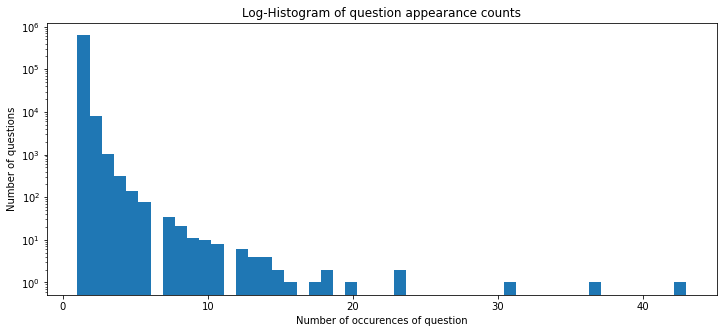

In [10]:
# Size of the plot
plt.figure(figsize=(12, 5))

# Distribution of the times each question occurs
plt.hist(question_count, bins=50)

# Take logarithm of y-value
plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

# Set axis labels
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')

# Show the plot
plt.show()

In [11]:
# The length of queation1 and question2
sizeQuestionOne = quora_train['question1'].str.len().tolist()
sizeQuestionTwo = quora_train['question2'].str.len().tolist()

min(sizeQuestionOne), min(sizeQuestionTwo), max(sizeQuestionOne), max(sizeQuestionTwo)

(1, 1, 418, 1139)

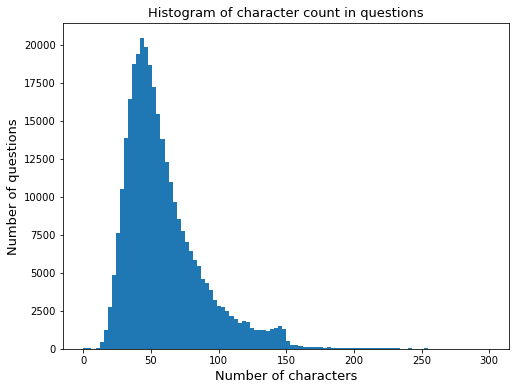

In [12]:
# Size of the plot
plt.figure(figsize=(8, 6))

# Distribution of the length of question 1
plt.hist(sizeQuestionOne, bins=100, range=[0, 300])

plt.title('Histogram of character count in questions', fontsize=13)

# Set axis labels
plt.xlabel('Number of characters', fontsize=13)
plt.ylabel('Number of questions', fontsize=13)

# Show the plot
plt.show()

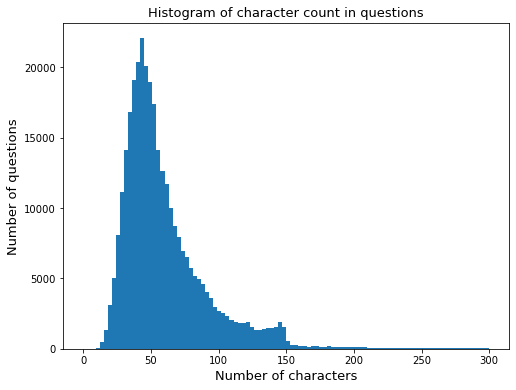

In [13]:
# Size of the plot
plt.figure(figsize=(8, 6))

# Distribution of the length of question 2
plt.hist(sizeQuestionTwo,bins=100, range=[0, 300])

plt.title('Histogram of character count in questions', fontsize=13)

# Set axis labels
plt.xlabel('Number of characters', fontsize=13)
plt.ylabel('Number of questions', fontsize=13)

# Show the plot
plt.show()

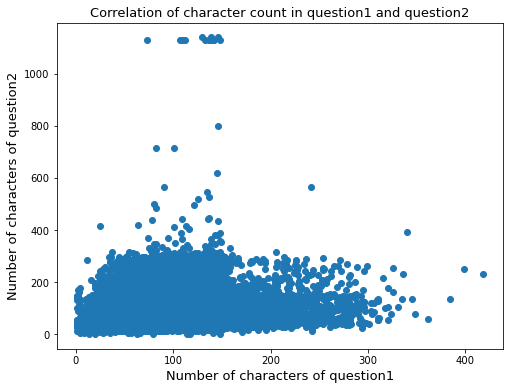

In [14]:
# Size of the plot
plt.figure(figsize=(8, 6))

# Relationship between the length of question 1 and question 2
plt.scatter(sizeQuestionOne, sizeQuestionTwo)

plt.title('Correlation of character count in question1 and question2', fontsize=13)

# Set axis labels
plt.xlabel('Number of characters of question1', fontsize=13)
plt.ylabel('Number of characters of question2', fontsize=13)

# Show the plot
plt.show()

In [15]:
# The number of words in question 1 and question 2
wordQuestionOne = quora_train['question1'].apply(lambda s: len(s.split(" ")))
wordQuestionTwo = quora_train['question2'].apply(lambda s: len(s.split(" ")))

min(wordQuestionOne), min(wordQuestionTwo), max(wordQuestionOne), max(wordQuestionTwo)

(1, 1, 80, 245)

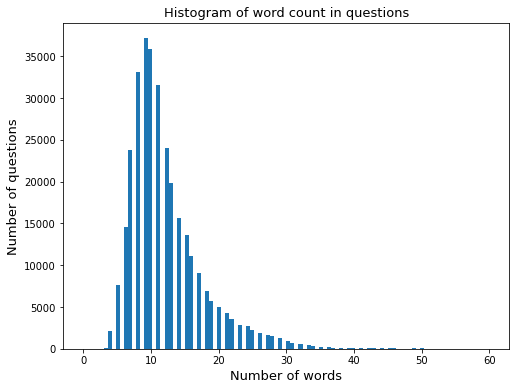

In [16]:
# Size of the plot
plt.figure(figsize=(8, 6))

# Distribution of the number of words in question 1
plt.hist(wordQuestionOne, bins=100, range=[0, 60])

plt.title('Histogram of word count in questions', fontsize=13)

# Set axis labels
plt.xlabel('Number of words', fontsize=13)
plt.ylabel('Number of questions', fontsize=13)

# Show the plot
plt.show()

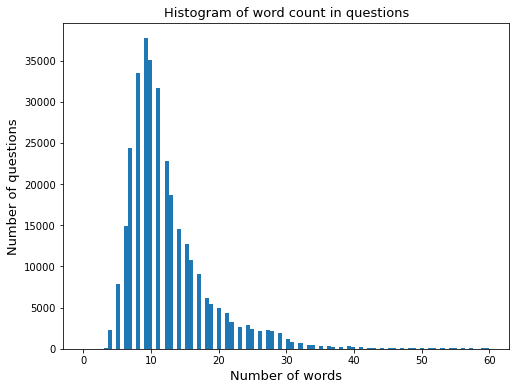

In [17]:
# Size of the plot
plt.figure(figsize=(8, 6))

# Distribution of the number of words in question 2
plt.hist(wordQuestionTwo, bins=100, range=[0, 60])

plt.title('Histogram of word count in questions', fontsize=13)

# Set axis labels
plt.xlabel('Number of words', fontsize=13)
plt.ylabel('Number of questions', fontsize=13)

# Show the plot
plt.show()

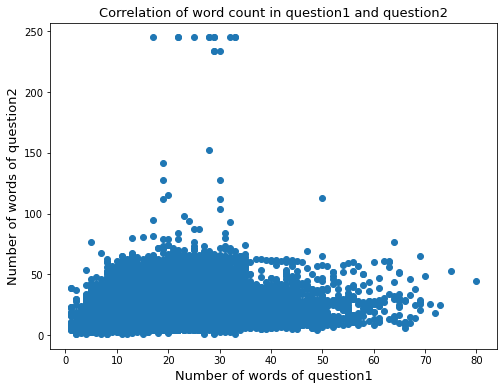

In [18]:
# Size of the plot
plt.figure(figsize=(8, 6))

# Relationship between the number of words in question1 and question2
plt.scatter(wordQuestionOne, wordQuestionTwo)

plt.title('Correlation of word count in question1 and question2', fontsize=13)

# Set axis labels
plt.xlabel('Number of words of question1', fontsize=13)
plt.ylabel('Number of words of question2', fontsize=13)

# Show the plot
plt.show()

In [19]:
def normalized_word_share(row):
    '''
    Compute the proportion of the same words in two texts
    '''
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

wordShare = quora_train.apply(normalized_word_share, axis=1)

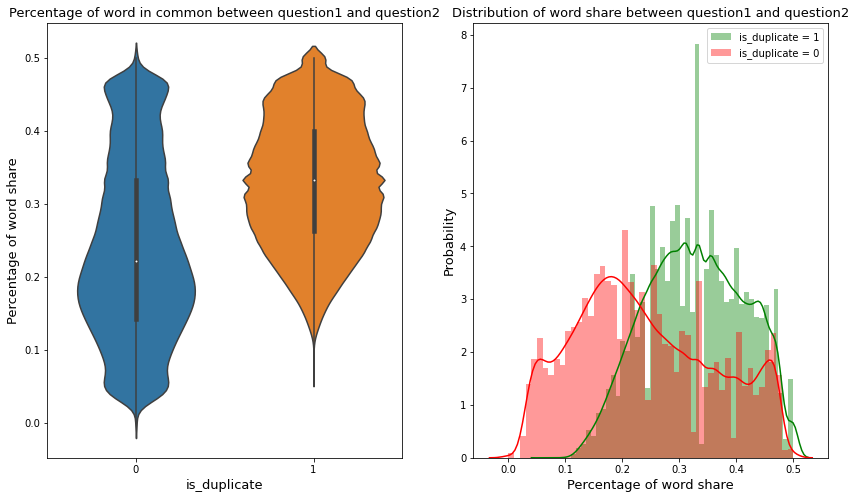

In [20]:
# Size of the plot
plt.figure(figsize=(14, 8))

plt.subplot(1,2,1)

# Distribution of word share for duplicate pairs and distinct pairs
sns.violinplot(x = quora_train['is_duplicate'], y = wordShare)

plt.title('Percentage of word in common between question1 and question2', fontsize=13)

# Set axis labels
plt.xlabel('is_duplicate', fontsize=13)
plt.ylabel('Percentage of word share', fontsize=13)


plt.subplot(1,2,2)
sns.distplot(wordShare[quora_train['is_duplicate'] == 1.0], color = 'green', label = 'is_duplicate = 1')
sns.distplot(wordShare[quora_train['is_duplicate'] == 0.0], color = 'red', label = 'is_duplicate = 0')

plt.title('Distribution of word share between question1 and question2', fontsize=13)

# Set axis labels
plt.xlabel('Percentage of word share', fontsize=13)
plt.ylabel('Probability', fontsize=13)

plt.legend()

# Show the plot
plt.show()

## 4. Modeling

In [21]:
# Parameters
MAX_SEQUENCE_LENGTH = 30 # Only the first 30 words in a text are taken into account
MAX_NB_WORDS = 200000 # Only the most common 200,000 words are to be tokenized
EMBEDDING_DIM = 300 # Dimension of embeddings

num_lstm = 205 # The output dimensionality of the LSTM layer
num_dense = 125 # The number of hidden units of the Dense layer
rate_drop_dense = 0.15 # The dropout rate of the Dropout layer

In [22]:
# Tokenize the words in all questions
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(quora_train['question1'].\
                       append([quora_train['question2'], quora_test['question1'], quora_test['question2']]))

sequences_1 = tokenizer.texts_to_sequences(quora_train['question1'])
sequences_2 = tokenizer.texts_to_sequences(quora_train['question2'])
test_sequences_1 = tokenizer.texts_to_sequences(quora_test['question1'])
test_sequences_2 = tokenizer.texts_to_sequences(quora_test['question2'])

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 85536 unique tokens


In [23]:
data_1 = pad_sequences(sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
data_2 = pad_sequences(sequences_2, maxlen=MAX_SEQUENCE_LENGTH)
labels = np.array(quora_train['is_duplicate'])
print('Shape of data tensor:', data_1.shape)
print('Shape of label tensor:', labels.shape)

test_data_1 = pad_sequences(test_sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
test_data_2 = pad_sequences(test_sequences_2, maxlen=MAX_SEQUENCE_LENGTH)

Shape of data tensor: (323478, 30)
Shape of label tensor: (323478,)


In [24]:
# Index word vectors
word2vec = KeyedVectors.load_word2vec_format('/kaggle/input/embedding/GoogleNews-vectors-negative300.bin', binary=True)
print('Found %s word vectors of word2vec' % len(word2vec.vocab))

# Prepare embeddings
print('Preparing embedding matrix')

nb_words = min(MAX_NB_WORDS, len(word_index))+1

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Found 3000000 word vectors of word2vec
Preparing embedding matrix
Null word embeddings: 37402


In [25]:
# Define the model structure
embedding_layer = Embedding(nb_words, EMBEDDING_DIM, weights=[embedding_matrix],\
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False)

lstm_layer = LSTM(num_lstm)

sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = lstm_layer(embedded_sequences_1)

sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
y1 = lstm_layer(embedded_sequences_2)

merged = concatenate([x1, y1])
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

merged = Dense(num_dense, activation= 'relu')(merged)
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

preds = Dense(1, activation='sigmoid')(merged)

In [26]:
# Sample train/validation data
VALIDATION_SPLIT = 0.2 # The proportion of validation data
perm = np.random.permutation(len(data_1)) # Shuffle the index
idx_train = perm[:int(len(data_1)*(1-VALIDATION_SPLIT))]
idx_val = perm[int(len(data_1)*(1-VALIDATION_SPLIT)):]

data_1_train = data_1[idx_train]
data_2_train = data_2[idx_train]
labels_train = labels[idx_train]

data_1_val = data_1[idx_val]
data_2_val = data_2[idx_val]
labels_val = labels[idx_val]

# Whether to re-weight classes to fit the 17.5% share in test set
re_weight = True

# Add class weight
if re_weight:
    class_weight = {0: 1.309028344, 1: 0.472001959}
else:
    class_weight = None

weight_val = np.ones(len(labels_val))
if re_weight:
    weight_val *= 0.472001959
    weight_val[labels_val==0] = 1.309028344

In [27]:
# Train the model
model = Model(inputs=[sequence_1_input, sequence_2_input], outputs=preds)
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])

hist = model.fit([data_1_train, data_2_train], labels_train, \
                 validation_data=([data_1_val, data_2_val], labels_val, weight_val), \
                 epochs=10, batch_size=128, shuffle=True, \
                 class_weight=class_weight)

Epoch 1/10
2022/2022 [==============================] - 39s 19ms/step - loss: 0.3839 - acc: 0.6974 - val_loss: 0.3416 - val_acc: 0.7118
Epoch 2/10
2022/2022 [==============================] - 39s 19ms/step - loss: 0.3294 - acc: 0.7331 - val_loss: 0.3251 - val_acc: 0.7480
Epoch 3/10
2022/2022 [==============================] - 38s 19ms/step - loss: 0.3069 - acc: 0.7560 - val_loss: 0.2996 - val_acc: 0.7709
Epoch 4/10
2022/2022 [==============================] - 38s 19ms/step - loss: 0.2885 - acc: 0.7756 - val_loss: 0.2954 - val_acc: 0.7774
Epoch 5/10
2022/2022 [==============================] - 38s 19ms/step - loss: 0.2712 - acc: 0.7937 - val_loss: 0.2920 - val_acc: 0.7937
Epoch 6/10
2022/2022 [==============================] - 38s 19ms/step - loss: 0.2556 - acc: 0.8093 - val_loss: 0.2899 - val_acc: 0.8076
Epoch 7/10
2022/2022 [==============================] - 38s 19ms/step - loss: 0.2420 - acc: 0.8224 - val_loss: 0.2887 - val_acc: 0.8123
Epoch 8/10
2022/2022 [==========================

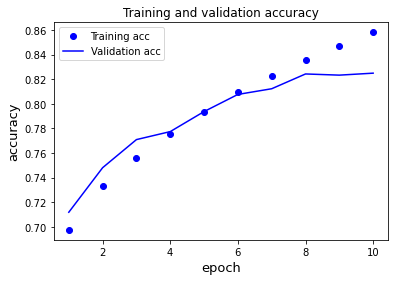

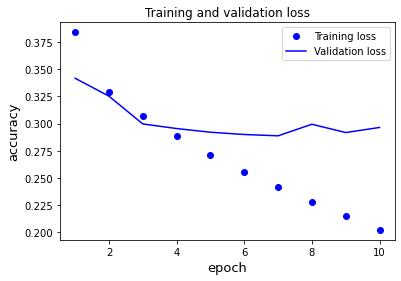

In [28]:
# The accuracy of the training data and validation data
acc = hist.history['acc']
val_acc = hist.history['val_acc']

# Loss of the training data and validation data
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

# Set axis labels
plt.xlabel('epoch', fontsize=13)
plt.ylabel('accuracy', fontsize=13)

plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

# Set axis labels
plt.xlabel('epoch', fontsize=13)
plt.ylabel('accuracy', fontsize=13)

plt.title('Training and validation loss')

plt.legend()

# Show the plot
plt.show()

In [29]:
# Run the model on test data
model.evaluate(x = [test_data_1, test_data_2], y = quora_test['is_duplicate'])

2528/2528 [==============================] - 12s 5ms/step - loss: 0.4185 - acc: 0.8270


[0.41852283477783203, 0.8270310163497925]

In [30]:
quora_test['prob'] = model.predict([test_data_1, test_data_2])

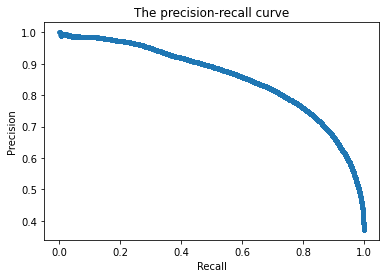

In [31]:
# Precision and recall
nn_precision, nn_recall, _ = precision_recall_curve(quora_test['is_duplicate'], quora_test['prob'])

# f-value
nn_f = 2*nn_precision*nn_recall / (nn_precision+nn_recall)

# Plot precision-recall curve
plt.plot(nn_recall, nn_precision, marker='.')

# Set axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('The precision-recall curve')

# Show the plot
plt.show()

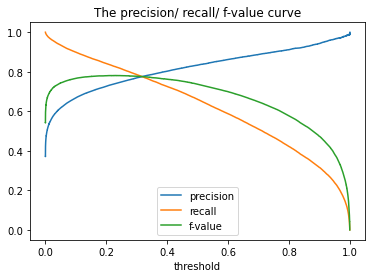

In [32]:
# The precision, recall and f-value curve
plt.plot(_, nn_precision[:-1], label = 'precision')
plt.plot(_, nn_recall[:-1], label = 'recall')
plt.plot(_, nn_f[:-1], label = 'f-value')

plt.legend(loc = 'lower center')

# Set axis label
plt.xlabel('threshold')

plt.title('The precision/ recall/ f-value curve')

# Show the plot
plt.show()

In [33]:
quora_test['pred'] = 0
quora_test.loc[quora_test['prob'] > 0.38, 'pred'] = 1 # The predicted label

quora_test

,id,qid1,qid2,question1,question2,is_duplicate,prob,pred
0,384611,752053,752054,what are the pros and cons of legalzoom - gene...,where can i read reviews of legalzoom,0,6.562344e-03,0
1,258398,508576,508577,why does ready - to - eat poha absorb water in...,ultimate teen patti hacker,0,1.376224e-08,0
2,234932,462847,462848,how apps like paytm earn profit when they are ...,how does paytm earn by giving extra cash back ...,1,5.165227e-01,1
3,347622,681123,681124,what daily habits can greatly upgrade life,what are your daily habits that improve your p...,1,2.588862e-01,0
4,388186,758881,758882,what video game world would you want to live in,if you could live in any video game setting wh...,1,9.428580e-01,1
...,...,...,...,...,...,...,...,...
80865,122770,243282,243283,what is your favourite beatles song and why do...,what is your favorite beatles song and why do ...,1,9.152474e-01,1
80866,276763,544162,544163,who has the legal authority to rule china clai...,how can i prove that every bounded and monoton...,0,2.669473e-04,0
80867,348359,682538,682539,what are the best simulator games for android,which are some best simulator games on android,1,7.926947e-01,1
80868,150536,297798,297799,how can some people still believe the world is...,why do some people currently believe the earth...,1,9.068120e-01,1


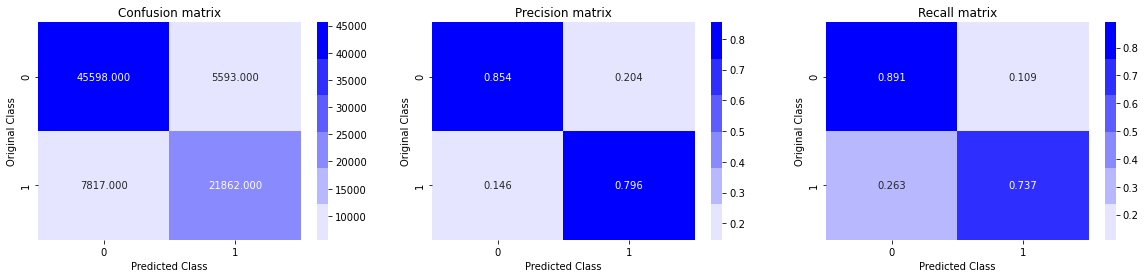

In [34]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))

    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()
    
plot_confusion_matrix(quora_test['is_duplicate'], quora_test['pred'])

In [35]:
# Compute the accuracy, precision, recall, and f-value given the threshold
print(accuracy_score(quora_test['is_duplicate'], quora_test['pred']))
print(precision_score(quora_test['is_duplicate'], quora_test['pred']))
print(recall_score(quora_test['is_duplicate'], quora_test['pred']))
print(f1_score(quora_test['is_duplicate'], quora_test['pred']))

0.8341783108692964
0.7962848297213623
0.7366151150645237
0.7652886197360591


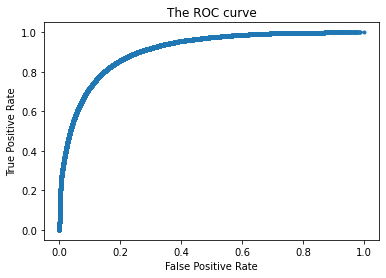

In [36]:
nn_fpr, nn_tpr, _ = roc_curve(quora_test['is_duplicate'], quora_test['prob'])

# Plot ROC curve
plt.plot(nn_fpr, nn_tpr, marker='.')

# Set axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The ROC curve')

# Show the plot
plt.show()

In [37]:
# Compute AUC
nn_auc = roc_auc_score(quora_test['is_duplicate'], quora_test['prob'])
print('ROC AUC=%.3f' % (nn_auc))

ROC AUC=0.909
